# Bug triage with Deep Learning

In [1]:
import keras
from tensorflow.contrib.tensorboard.plugins import projector

C:\Users\Thiago\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from __future__ import print_function, division

In [3]:
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

In [4]:
from keras.layers import Conv1D, Input, Add, Activation, Dropout, Embedding, MaxPooling1D, GlobalMaxPool1D, Flatten, Dense, Concatenate, BatchNormalization
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.initializers import TruncatedNormal
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras import optimizers

In [5]:
from methods.baseline import Baseline

## Auxiliary methods

## Configurações Globais

In [6]:
MAX_SEQUENCE_LENGTH_T = 100 # 40
MAX_SEQUENCE_LENGTH_D = 100 # 200
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000

### Parse bugs preproprecessed

In [7]:
DIR = 'data/processed/eclipse'
DIR_PAIRS = 'data/normalized/eclipse'

In [8]:
df_train_pair = pd.read_csv(os.path.join(DIR_PAIRS, 'eclipse_pairs.csv'))
baseline = Baseline(DIR, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)

#### Loading bug ids in memory

In [9]:
baseline.load_ids(DIR)

In [10]:
len(baseline.bug_ids)

212512

### Dicionário de títulos e descrições

In [11]:
%%time

baseline.load_preprocess()

100%|█████████████████████████████████| 212512/212512 [22:38<00:00, 156.46it/s]


Wall time: 22min 38s


In [12]:
len(baseline.sentence_dict)

411418

## Geração de batches

### Generating tiple of batches

In [13]:
%%time

bug_dir = os.path.join(DIR)
baseline.prepare_dataset(bug_dir)

Reading train data
Wall time: 1.27 s


In [14]:
baseline.load_bugs()

100%|█████████████████████████████████| 212512/212512 [14:13<00:00, 249.06it/s]


In [13]:
df = pd.read_csv('data/normalized/eclipse/eclipse.csv')

In [20]:
df[df['bug_id'] == 2521][['description', 'short_desc']].values

array([['STEPS:\n0. Minimize all your windows\n1. Go to any window and select the Window menu\n2. Pick any window\nNotice that it only gets selected and not maximized.\n\nThis happens in Linux as well.\n\n\nNOTES:',
        'Selecting a window in the window menu does not maximize window (1GFITIC)']],
      dtype=object)

In [13]:
baseline.bug_set[2521]

{'issue_id': 2521,
 'bug_severity': 'enhancement',
 'bug_status': 'CLOSED',
 'component': 'UI',
 'creation_ts': '2001-10-10 22:38:00 -0400',
 'delta_ts': '2005-05-10 14:55:51 -0400',
 'description': 'steps number minimize all your windows number go to any window and select the window menu number pick any window notice that it only gets selected and not maximized this happens in linux as well notes',
 'dup_id': '[]',
 'priority': 'P3',
 'product': 'Platform',
 'resolution': 'FIXED',
 'title': 'selecting a window in the window menu does not maximize window numbergfitic',
 'version': '2.0',
 'description_word': array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  

In [15]:
%%time

batch_size = 512
batch_size_test = 512

# we want a constant validation group to have a frame of reference for model performance
train_gen = baseline.siam_gen(bug_dir, batch_size, 1)
valid_input_sample, valid_input_pos, valid_input_neg, valid_sim = baseline.batch_iterator(bug_dir, batch_size_test, 1)
test_gen = ([valid_input_sample['title'], valid_input_pos['title'], valid_input_neg['title'], 
             valid_input_sample['description'], valid_input_pos['description'], valid_input_neg['description']], valid_sim)

Wall time: 374 ms


In [16]:
valid_input_sample['title'].shape, valid_input_sample['description'].shape, valid_sim.shape

((512, 100), (512, 100), (512,))

### Validar entrada

In [17]:
%%time 

baseline.display_batch(bug_dir, 5)

Title: 
fatal error when running with blocked network
Title: 
debug jvmti error internal number
Description: 
eclipse rcnumber windows xp i am running the zone lab integrity client firewall and trying to debug network code in eclipse update install when i turn off internet connections from the firewall eclipse does not start in debug mode and output this error err no such file or directory fatal error in native method no transports initialized error number in connect call socket transport failed to init transport dt socket failed to initialize rc number
Description: 
hello i installed eclipse sdk number winnumber jrenumber jdknumber and jnumberrenumber successfully i can run my java application but when i start the debugger the following error is displayed fatal error in native method jdwp no transports initialized jvmti error jvmti error internal number error transport error number connect failed connection refused transport c lnumber error jdwp transport dt socket failed to initializ

## Pre-trained embeddings

Loading pretrained word vectors

### Glove

In [18]:
%%time

baseline.generating_embed(GLOVE_DIR='data/embed', EMBEDDING_DIM=EMBEDDING_DIM, MAX_NB_WORDS=MAX_NB_WORDS)

1917494it [17:21, 1841.29it/s]


Total 1917494 word vectors in Glove 42B 300d.
Found 157117 unique tokens.


100%|██████████████████████████████| 157117/157117 [00:00<00:00, 327758.16it/s]


Wall time: 19min 20s


## Towards Accurate Duplicate Bug Retrieval Using Deep Learning Techniques

https://github.com/tqtg/DuplicateBugFinder

### CNN with filter 3,4,5

In [19]:
import keras
from keras.layers import GlobalMaxPooling1D 

keras.backend.clear_session()

def cnn_model(embeddings, num_words, embedding_dim, max_sequence_length, trainable):

  embedding_layer = Embedding(num_words,
                              embedding_dim,
                              weights=[embeddings],
                              input_length=max_sequence_length,
                              trainable=trainable)

  sequence_input = Input(shape=(max_sequence_length,), name='Feature_BugInput')
  embedded_sequences = embedding_layer(sequence_input)

  # Yoon Kim model (https://arxiv.org/abs/1408.5882)
  convs = []
  filter_sizes = [3,4,5]

  for filter_size in filter_sizes:
      l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
      l_pool = MaxPooling1D(pool_size=3)(l_conv)
      convs.append(l_pool)

  # l_merge = Merge(mode='concat', concat_axis=1)(convs)

  l_merge = Concatenate(axis=1)(convs)

  # add a 1D convnet with global maxpooling, instead of Yoon Kim model
  conv = Conv1D(filters=256, kernel_size=3, activation='relu')(l_merge)
  layer = GlobalMaxPooling1D()(conv) # pool_size=3
  # Original Yoon Kim model
  #x = Flatten()(pool)
  #x = Dropout(0.5)(x)
  #layer = Activation('relu')(pool)

  cnn_feature_model = Model(inputs=[sequence_input], outputs=[layer], name = 'FeatureCNNGenerationModel') # inputs=visible
  
  return cnn_feature_model

### Bi-LSTM

In [20]:
from keras.layers import Dense, Input, LSTM, Dropout, Bidirectional

def lstm_model(embeddings, num_words, embedding_dim, max_sequence_length, trainable):
  number_lstm_units = 200
  rate_drop_lstm = 0
  recurrent_dropout = 0

  embedding_layer = Embedding(num_words,
                          embedding_dim,
                          weights=[embeddings],
                          input_length=max_sequence_length,
                          trainable=trainable)

  sequence_input = Input(shape=(max_sequence_length, ), name='Feature_BugInput')
  embedded_sequences = embedding_layer(sequence_input)

   # Creating LSTM Encoder
  lstm_layer = Bidirectional(LSTM(number_lstm_units, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm), merge_mode='sum')

  layer = lstm_layer(embedded_sequences)

  #layer = Activation('relu')(x)

  lstm_feature_model = Model(inputs=[sequence_input], outputs=[layer], name = 'FeatureLstmGenerationModel') # inputs=visible
  
  return lstm_feature_model

### Siamese model

In [21]:
from keras import backend as K
import tensorflow as tf

def l2_normalize(x, axis):
    norm = K.sqrt(K.sum(K.square(x), axis=axis, keepdims=True))
    return K.maximum(x, K.epsilon()) / K.maximum(norm, K.epsilon())

# https://github.com/keras-team/keras/issues/3031
# https://github.com/keras-team/keras/issues/8335
def cosine_distance(inputs):
    x, y = inputs
    x = l2_normalize(x, axis=-1)
    y = l2_normalize(y, axis=-1)
    similarity = K.batch_dot(x, y, axes=1)
    distance = K.constant(1) - similarity
    # Distance goes from 0 to 2 in theory, but from 0 to 1 if x and y are both
    # positive (which is the case after ReLU activation).
    return K.mean(distance, axis=-1)

def margin_loss(y_true, y_pred):
    margin = K.constant(1.0)
    return K.mean(K.maximum(0.0, margin - y_pred[0] + y_pred[1]))

def pos_distance(y_true, y_pred):
    return K.mean(y_pred[0])

def neg_distance(y_true, y_pred):
    return K.mean(y_pred[1])

def stack_tensors(vects):
    return K.squeeze(K.stack(vects),axis=1) # stack adds a new dim. So squeeze it
    # better method is to use concatenate
    return K.concatenate(vects,axis=1)

In [22]:
from keras.layers import concatenate, Add, Lambda, merge
from keras.optimizers import Adam

def siamese_model(lstm_feature_model, cnn_feature_model, max_sequence_length_t, max_sequence_length_d):
  
    bug_t_in = Input(shape = (max_sequence_length_t, ), name = 'title_in')
    bug_t_pos = Input(shape = (max_sequence_length_t, ), name = 'title_pos')
    bug_t_neg = Input(shape = (max_sequence_length_t, ), name = 'title_neg')

    bug_d_in = Input(shape = (max_sequence_length_d, ), name = 'desc_in')
    bug_d_pos = Input(shape = (max_sequence_length_d, ), name = 'desc_pos')
    bug_d_neg = Input(shape = (max_sequence_length_d, ), name = 'desc_neg')

    bug_t_in_feat_lstm = lstm_feature_model(bug_t_in)
    bug_t_pos_feat_lstm = lstm_feature_model(bug_t_pos)
    bug_t_neg_feat_lstm = lstm_feature_model(bug_t_neg)

    bug_d_in_feat_cnn = cnn_feature_model(bug_d_in)
    bug_d_pos_feat_cnn = cnn_feature_model(bug_d_pos)
    bug_d_neg_feat_cnn = cnn_feature_model(bug_d_neg)

    encoded_anchor = concatenate([bug_t_in_feat_lstm, bug_d_in_feat_cnn], name = 'merge_features_in')
    encoded_positive = concatenate([bug_t_pos_feat_lstm, bug_d_pos_feat_cnn], name = 'merge_features_pos')
    encoded_negative = concatenate([bug_t_neg_feat_lstm, bug_d_neg_feat_cnn], name = 'merge_features_neg')

    positive_d = Lambda(cosine_distance)([encoded_anchor, encoded_positive])
    negative_d = Lambda(cosine_distance)([encoded_anchor, encoded_negative])
    
    # Loss function only works with a single output
    output = Lambda(
        lambda vects: K.stack(vects),
        name='stack-distances',
    )([positive_d, negative_d])
  
    similarity_model = Model(inputs = [bug_t_in, bug_t_pos, bug_t_neg, bug_d_in, bug_d_pos, bug_d_neg], 
                           outputs = output, name = 'Similarity_Model')

    # setup the optimization process 
    similarity_model.compile(optimizer='adam', loss=margin_loss, metrics=[pos_distance, neg_distance]) # 'categorical_crossentropy' 

    return similarity_model

## Experiment

In [ ]:
%%time
import keras
from keras.callbacks import ModelCheckpoint

# Inspired on https://pastebin.com/TaGFdcBA
# TODO: https://stackoverflow.com/questions/49941903/keras-compute-cosine-distance-between-two-flattened-outputs
keras.backend.clear_session()

cnn_feature_model = cnn_model(embeddings=baseline.embedding_matrix, 
                              num_words=len(baseline.word_index) + 1, 
                              embedding_dim=EMBEDDING_DIM, 
                              max_sequence_length=MAX_SEQUENCE_LENGTH_D, 
                              trainable=False)

lstm_feature_model = lstm_model(embeddings=baseline.embedding_matrix, 
                              num_words=len(baseline.word_index) + 1, 
                              embedding_dim=EMBEDDING_DIM, 
                              max_sequence_length=MAX_SEQUENCE_LENGTH_T, 
                              trainable=False)

similarity_model = siamese_model(lstm_feature_model, cnn_feature_model, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)

# cnn_feature_model.summary()
# lstm_feature_model.summary()
similarity_model.summary()

tbCallBack = keras.callbacks.TensorBoard(log_dir='logs/training', histogram_freq=0, write_graph=True, write_images=True)
# checkpoint
filepath="baseline_1000epoch_10steps_512batch(eclipse)_new.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

h = similarity_model.fit_generator(train_gen, 
                               steps_per_epoch = 10,
                               #validation_data=test_gen, # 
                                             epochs = 100,
                                             verbose = True,
                                               callbacks=[tbCallBack, checkpoint]
                                              )  # 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_in (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
desc_in (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
title_pos (InputLayer)          (None, 100)          0                                            
__________________________________________________________________________________________________
desc_pos (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
title_neg 

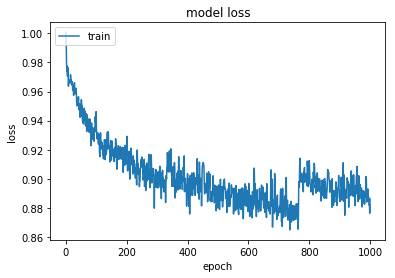

In [31]:
loss=h.history['loss']

plt.plot(loss, label='loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

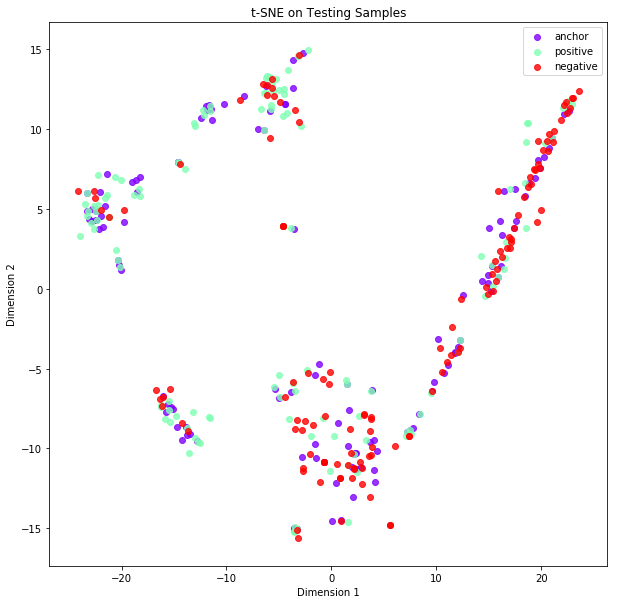

Wall time: 14.8 s


In [37]:
%%time
baseline.display_embed_space(similarity_model, 128)

In [44]:
name = 'baseline_1000epoch_10steps_512batch(eclipse)'
Baseline.save_model('', similarity_model, name)

Saved model to disk


## Training with more 1000 epochs

In [45]:
h_2000epochs = similarity_model.fit_generator(train_gen, 
                               steps_per_epoch = 10,
                                             epochs = 1000,
                                             verbose = True,
                                               callbacks=[tbCallBack, checkpoint]
                                              )  # 

Epoch 1/1000
10/10 [==============================] - ETA: 1:11:37 - loss: 0.8573 - pos_distance: 0.4959 - neg_distance: 0.35 - ETA: 34:57 - loss: 0.8660 - pos_distance: 0.5131 - neg_distance: 0.3791 - ETA: 23:38 - loss: 0.8772 - pos_distance: 0.5056 - neg_distance: 0.38 - ETA: 17:21 - loss: 0.8860 - pos_distance: 0.5029 - neg_distance: 0.38 - ETA: 12:34 - loss: 0.8874 - pos_distance: 0.4899 - neg_distance: 0.37 - ETA: 8:56 - loss: 0.8888 - pos_distance: 0.4769 - neg_distance: 0.3657 - ETA: 6:05 - loss: 0.8855 - pos_distance: 0.4622 - neg_distance: 0.347 - ETA: 3:46 - loss: 0.8882 - pos_distance: 0.4512 - neg_distance: 0.339 - ETA: 1:48 - loss: 0.8861 - pos_distance: 0.4487 - neg_distance: 0.334 - 1031s 103s/step - loss: 0.8844 - pos_distance: 0.4539 - neg_distance: 0.3383

Epoch 00001: loss did not improve from 0.86478
Epoch 2/1000
10/10 [==============================] - ETA: 7:57 - loss: 0.8880 - pos_distance: 0.4521 - neg_distance: 0.340 - ETA: 7:02 - loss: 0.8804 - pos_distance: 0


Epoch 00010: loss did not improve from 0.86478
Epoch 11/1000
10/10 [==============================] - ETA: 5:06 - loss: 0.8828 - pos_distance: 0.4137 - neg_distance: 0.296 - ETA: 4:31 - loss: 0.8920 - pos_distance: 0.4369 - neg_distance: 0.328 - ETA: 3:57 - loss: 0.8915 - pos_distance: 0.4633 - neg_distance: 0.354 - ETA: 3:25 - loss: 0.8985 - pos_distance: 0.4771 - neg_distance: 0.375 - ETA: 2:52 - loss: 0.8998 - pos_distance: 0.4853 - neg_distance: 0.385 - ETA: 2:18 - loss: 0.8995 - pos_distance: 0.4766 - neg_distance: 0.376 - ETA: 1:44 - loss: 0.8985 - pos_distance: 0.4631 - neg_distance: 0.361 - ETA: 1:09 - loss: 0.9007 - pos_distance: 0.4469 - neg_distance: 0.347 - ETA: 34s - loss: 0.9028 - pos_distance: 0.4422 - neg_distance: 0.344 - 353s 35s/step - loss: 0.9005 - pos_distance: 0.4505 - neg_distance: 0.3509

Epoch 00011: loss did not improve from 0.86478
Epoch 12/1000
10/10 [==============================] - ETA: 5:13 - loss: 0.8876 - pos_distance: 0.6006 - neg_distance: 0.488 - 


Epoch 00020: loss did not improve from 0.86478
Epoch 21/1000
10/10 [==============================] - ETA: 5:53 - loss: 0.8854 - pos_distance: 0.4369 - neg_distance: 0.322 - ETA: 4:53 - loss: 0.8897 - pos_distance: 0.4497 - neg_distance: 0.339 - ETA: 4:11 - loss: 0.8898 - pos_distance: 0.4581 - neg_distance: 0.347 - ETA: 3:34 - loss: 0.8928 - pos_distance: 0.4632 - neg_distance: 0.356 - ETA: 2:58 - loss: 0.8907 - pos_distance: 0.4652 - neg_distance: 0.355 - ETA: 2:22 - loss: 0.8887 - pos_distance: 0.4588 - neg_distance: 0.347 - ETA: 1:46 - loss: 0.8865 - pos_distance: 0.4486 - neg_distance: 0.335 - ETA: 1:10 - loss: 0.8873 - pos_distance: 0.4414 - neg_distance: 0.328 - ETA: 35s - loss: 0.8855 - pos_distance: 0.4444 - neg_distance: 0.329 - 351s 35s/step - loss: 0.8851 - pos_distance: 0.4545 - neg_distance: 0.3396

Epoch 00021: loss did not improve from 0.86478
Epoch 22/1000
10/10 [==============================] - ETA: 4:54 - loss: 0.8823 - pos_distance: 0.5550 - neg_distance: 0.437 - 


Epoch 00030: loss did not improve from 0.86478
Epoch 31/1000
10/10 [==============================] - ETA: 4:31 - loss: 0.8913 - pos_distance: 0.4501 - neg_distance: 0.341 - ETA: 4:07 - loss: 0.8825 - pos_distance: 0.4674 - neg_distance: 0.349 - ETA: 3:35 - loss: 0.8822 - pos_distance: 0.4709 - neg_distance: 0.353 - ETA: 3:04 - loss: 0.8888 - pos_distance: 0.4728 - neg_distance: 0.361 - ETA: 2:33 - loss: 0.8861 - pos_distance: 0.4728 - neg_distance: 0.359 - ETA: 2:02 - loss: 0.8887 - pos_distance: 0.4607 - neg_distance: 0.349 - ETA: 1:31 - loss: 0.8852 - pos_distance: 0.4521 - neg_distance: 0.337 - ETA: 1:04 - loss: 0.8841 - pos_distance: 0.4478 - neg_distance: 0.331 - ETA: 32s - loss: 0.8847 - pos_distance: 0.4512 - neg_distance: 0.335 - 322s 32s/step - loss: 0.8836 - pos_distance: 0.4555 - neg_distance: 0.3391

Epoch 00031: loss did not improve from 0.86478
Epoch 32/1000
10/10 [==============================] - ETA: 4:20 - loss: 0.8731 - pos_distance: 0.5515 - neg_distance: 0.424 - 


Epoch 00040: loss did not improve from 0.86478
Epoch 41/1000
10/10 [==============================] - ETA: 4:24 - loss: 0.8974 - pos_distance: 0.3970 - neg_distance: 0.294 - ETA: 4:31 - loss: 0.8927 - pos_distance: 0.4120 - neg_distance: 0.304 - ETA: 3:47 - loss: 0.8902 - pos_distance: 0.4189 - neg_distance: 0.309 - ETA: 3:13 - loss: 0.8851 - pos_distance: 0.4253 - neg_distance: 0.310 - ETA: 2:39 - loss: 0.8879 - pos_distance: 0.4298 - neg_distance: 0.317 - ETA: 2:06 - loss: 0.8836 - pos_distance: 0.4407 - neg_distance: 0.324 - ETA: 1:34 - loss: 0.8866 - pos_distance: 0.4386 - neg_distance: 0.325 - ETA: 1:03 - loss: 0.8871 - pos_distance: 0.4363 - neg_distance: 0.323 - ETA: 31s - loss: 0.8889 - pos_distance: 0.4348 - neg_distance: 0.323 - 320s 32s/step - loss: 0.8897 - pos_distance: 0.4341 - neg_distance: 0.3239

Epoch 00041: loss did not improve from 0.86478
Epoch 42/1000
10/10 [==============================] - ETA: 4:56 - loss: 0.9216 - pos_distance: 0.3697 - neg_distance: 0.291 - 


Epoch 00050: loss did not improve from 0.86478
Epoch 51/1000
10/10 [==============================] - ETA: 4:41 - loss: 0.8934 - pos_distance: 0.3311 - neg_distance: 0.224 - ETA: 4:41 - loss: 0.8997 - pos_distance: 0.3061 - neg_distance: 0.205 - ETA: 3:59 - loss: 0.9040 - pos_distance: 0.3547 - neg_distance: 0.258 - ETA: 3:25 - loss: 0.8985 - pos_distance: 0.3955 - neg_distance: 0.294 - ETA: 2:51 - loss: 0.8944 - pos_distance: 0.4165 - neg_distance: 0.310 - ETA: 2:17 - loss: 0.8954 - pos_distance: 0.4213 - neg_distance: 0.316 - ETA: 1:42 - loss: 0.8863 - pos_distance: 0.4202 - neg_distance: 0.306 - ETA: 1:07 - loss: 0.8847 - pos_distance: 0.4112 - neg_distance: 0.295 - ETA: 33s - loss: 0.8820 - pos_distance: 0.4045 - neg_distance: 0.286 - 338s 34s/step - loss: 0.8831 - pos_distance: 0.3993 - neg_distance: 0.2824

Epoch 00051: loss did not improve from 0.86478
Epoch 52/1000
10/10 [==============================] - ETA: 5:17 - loss: 0.8624 - pos_distance: 0.4615 - neg_distance: 0.323 - 


Epoch 00060: loss did not improve from 0.86478
Epoch 61/1000
10/10 [==============================] - ETA: 4:53 - loss: 0.8964 - pos_distance: 0.5105 - neg_distance: 0.406 - ETA: 4:21 - loss: 0.8925 - pos_distance: 0.4734 - neg_distance: 0.365 - ETA: 3:45 - loss: 0.8914 - pos_distance: 0.4442 - neg_distance: 0.335 - ETA: 3:12 - loss: 0.8924 - pos_distance: 0.4184 - neg_distance: 0.310 - ETA: 2:40 - loss: 0.8894 - pos_distance: 0.4082 - neg_distance: 0.297 - ETA: 2:08 - loss: 0.8886 - pos_distance: 0.4124 - neg_distance: 0.300 - ETA: 1:36 - loss: 0.8914 - pos_distance: 0.4160 - neg_distance: 0.307 - ETA: 1:04 - loss: 0.8938 - pos_distance: 0.4232 - neg_distance: 0.317 - ETA: 32s - loss: 0.8922 - pos_distance: 0.4257 - neg_distance: 0.317 - 327s 33s/step - loss: 0.8919 - pos_distance: 0.4238 - neg_distance: 0.3157

Epoch 00061: loss did not improve from 0.86478
Epoch 62/1000
10/10 [==============================] - ETA: 5:06 - loss: 0.8911 - pos_distance: 0.3603 - neg_distance: 0.251 - 


Epoch 00070: loss did not improve from 0.86478
Epoch 71/1000
10/10 [==============================] - ETA: 4:31 - loss: 0.8521 - pos_distance: 0.4094 - neg_distance: 0.261 - ETA: 3:59 - loss: 0.8536 - pos_distance: 0.3891 - neg_distance: 0.242 - ETA: 3:33 - loss: 0.8593 - pos_distance: 0.3955 - neg_distance: 0.254 - ETA: 3:00 - loss: 0.8674 - pos_distance: 0.4267 - neg_distance: 0.294 - ETA: 2:32 - loss: 0.8664 - pos_distance: 0.4442 - neg_distance: 0.310 - ETA: 2:02 - loss: 0.8725 - pos_distance: 0.4419 - neg_distance: 0.314 - ETA: 1:32 - loss: 0.8754 - pos_distance: 0.4303 - neg_distance: 0.305 - ETA: 1:02 - loss: 0.8772 - pos_distance: 0.4260 - neg_distance: 0.303 - ETA: 31s - loss: 0.8781 - pos_distance: 0.4297 - neg_distance: 0.307 - 313s 31s/step - loss: 0.8738 - pos_distance: 0.4349 - neg_distance: 0.3086

Epoch 00071: loss did not improve from 0.86478
Epoch 72/1000
10/10 [==============================] - ETA: 4:46 - loss: 0.8861 - pos_distance: 0.4555 - neg_distance: 0.341 - 


Epoch 00080: loss did not improve from 0.86478
Epoch 81/1000
10/10 [==============================] - ETA: 4:54 - loss: 0.8754 - pos_distance: 0.4191 - neg_distance: 0.294 - ETA: 4:27 - loss: 0.8792 - pos_distance: 0.3915 - neg_distance: 0.270 - ETA: 3:54 - loss: 0.8804 - pos_distance: 0.4028 - neg_distance: 0.283 - ETA: 3:20 - loss: 0.8814 - pos_distance: 0.4127 - neg_distance: 0.294 - ETA: 2:47 - loss: 0.8761 - pos_distance: 0.4211 - neg_distance: 0.297 - ETA: 2:13 - loss: 0.8798 - pos_distance: 0.4166 - neg_distance: 0.296 - ETA: 1:40 - loss: 0.8818 - pos_distance: 0.4073 - neg_distance: 0.289 - ETA: 1:06 - loss: 0.8833 - pos_distance: 0.4008 - neg_distance: 0.284 - ETA: 33s - loss: 0.8848 - pos_distance: 0.4015 - neg_distance: 0.286 - 333s 33s/step - loss: 0.8829 - pos_distance: 0.4099 - neg_distance: 0.2929

Epoch 00081: loss did not improve from 0.86478
Epoch 82/1000
10/10 [==============================] - ETA: 4:55 - loss: 0.9318 - pos_distance: 0.4881 - neg_distance: 0.419 - 


Epoch 00090: loss did not improve from 0.86478
Epoch 91/1000
10/10 [==============================] - ETA: 4:57 - loss: 0.8927 - pos_distance: 0.3836 - neg_distance: 0.276 - ETA: 4:26 - loss: 0.8807 - pos_distance: 0.4089 - neg_distance: 0.289 - ETA: 3:53 - loss: 0.8946 - pos_distance: 0.4120 - neg_distance: 0.306 - ETA: 3:21 - loss: 0.8938 - pos_distance: 0.4242 - neg_distance: 0.318 - ETA: 2:46 - loss: 0.8904 - pos_distance: 0.4261 - neg_distance: 0.316 - ETA: 2:13 - loss: 0.8865 - pos_distance: 0.4190 - neg_distance: 0.305 - ETA: 1:39 - loss: 0.8867 - pos_distance: 0.4097 - neg_distance: 0.296 - ETA: 1:06 - loss: 0.8875 - pos_distance: 0.3977 - neg_distance: 0.285 - ETA: 33s - loss: 0.8879 - pos_distance: 0.3984 - neg_distance: 0.286 - 335s 34s/step - loss: 0.8858 - pos_distance: 0.4038 - neg_distance: 0.2896

Epoch 00091: loss did not improve from 0.86478
Epoch 92/1000
10/10 [==============================] - ETA: 5:03 - loss: 0.8783 - pos_distance: 0.4906 - neg_distance: 0.368 - 


Epoch 00100: loss did not improve from 0.86478
Epoch 101/1000
10/10 [==============================] - ETA: 4:23 - loss: 0.8822 - pos_distance: 0.4412 - neg_distance: 0.323 - ETA: 3:51 - loss: 0.8995 - pos_distance: 0.4480 - neg_distance: 0.347 - ETA: 3:22 - loss: 0.8841 - pos_distance: 0.4659 - neg_distance: 0.350 - ETA: 2:53 - loss: 0.8800 - pos_distance: 0.4639 - neg_distance: 0.343 - ETA: 2:25 - loss: 0.8812 - pos_distance: 0.4549 - neg_distance: 0.336 - ETA: 1:55 - loss: 0.8820 - pos_distance: 0.4392 - neg_distance: 0.321 - ETA: 1:27 - loss: 0.8811 - pos_distance: 0.4323 - neg_distance: 0.313 - ETA: 58s - loss: 0.8829 - pos_distance: 0.4380 - neg_distance: 0.320 - ETA: 29s - loss: 0.8803 - pos_distance: 0.4448 - neg_distance: 0.32 - 292s 29s/step - loss: 0.8810 - pos_distance: 0.4529 - neg_distance: 0.3339

Epoch 00101: loss did not improve from 0.86478
Epoch 102/1000
10/10 [==============================] - ETA: 4:15 - loss: 0.8869 - pos_distance: 0.4715 - neg_distance: 0.358 - 


Epoch 00110: loss did not improve from 0.86478
Epoch 111/1000
10/10 [==============================] - ETA: 4:06 - loss: 0.8747 - pos_distance: 0.5235 - neg_distance: 0.398 - ETA: 3:47 - loss: 0.8637 - pos_distance: 0.5185 - neg_distance: 0.382 - ETA: 3:33 - loss: 0.8792 - pos_distance: 0.4844 - neg_distance: 0.363 - ETA: 3:00 - loss: 0.8768 - pos_distance: 0.4646 - neg_distance: 0.341 - ETA: 2:29 - loss: 0.8766 - pos_distance: 0.4460 - neg_distance: 0.322 - ETA: 1:58 - loss: 0.8741 - pos_distance: 0.4407 - neg_distance: 0.314 - ETA: 1:28 - loss: 0.8808 - pos_distance: 0.4472 - neg_distance: 0.328 - ETA: 58s - loss: 0.8855 - pos_distance: 0.4570 - neg_distance: 0.342 - ETA: 29s - loss: 0.8894 - pos_distance: 0.4683 - neg_distance: 0.35 - 292s 29s/step - loss: 0.8935 - pos_distance: 0.4736 - neg_distance: 0.3672

Epoch 00111: loss did not improve from 0.86478
Epoch 112/1000
10/10 [==============================] - ETA: 4:29 - loss: 0.8988 - pos_distance: 0.4766 - neg_distance: 0.375 - 


Epoch 00120: loss did not improve from 0.86478
Epoch 121/1000
10/10 [==============================] - ETA: 4:33 - loss: 0.9019 - pos_distance: 0.4241 - neg_distance: 0.326 - ETA: 3:54 - loss: 0.8834 - pos_distance: 0.4331 - neg_distance: 0.316 - ETA: 3:21 - loss: 0.8827 - pos_distance: 0.4333 - neg_distance: 0.316 - ETA: 2:52 - loss: 0.8788 - pos_distance: 0.4362 - neg_distance: 0.314 - ETA: 2:24 - loss: 0.8885 - pos_distance: 0.4348 - neg_distance: 0.323 - ETA: 1:55 - loss: 0.8869 - pos_distance: 0.4346 - neg_distance: 0.321 - ETA: 1:26 - loss: 0.8908 - pos_distance: 0.4330 - neg_distance: 0.323 - ETA: 58s - loss: 0.8918 - pos_distance: 0.4279 - neg_distance: 0.319 - ETA: 28s - loss: 0.8945 - pos_distance: 0.4195 - neg_distance: 0.31 - 289s 29s/step - loss: 0.8973 - pos_distance: 0.4129 - neg_distance: 0.3102

Epoch 00121: loss did not improve from 0.86478
Epoch 122/1000
10/10 [==============================] - ETA: 4:20 - loss: 0.9010 - pos_distance: 0.4426 - neg_distance: 0.343 - 


Epoch 00130: loss did not improve from 0.86478
Epoch 131/1000
10/10 [==============================] - ETA: 4:33 - loss: 0.8760 - pos_distance: 0.4227 - neg_distance: 0.298 - ETA: 3:55 - loss: 0.8730 - pos_distance: 0.4323 - neg_distance: 0.305 - ETA: 3:24 - loss: 0.8702 - pos_distance: 0.4332 - neg_distance: 0.303 - ETA: 2:54 - loss: 0.8683 - pos_distance: 0.4448 - neg_distance: 0.313 - ETA: 2:24 - loss: 0.8707 - pos_distance: 0.4537 - neg_distance: 0.324 - ETA: 1:57 - loss: 0.8698 - pos_distance: 0.4568 - neg_distance: 0.326 - ETA: 1:27 - loss: 0.8740 - pos_distance: 0.4535 - neg_distance: 0.327 - ETA: 58s - loss: 0.8705 - pos_distance: 0.4538 - neg_distance: 0.324 - ETA: 29s - loss: 0.8743 - pos_distance: 0.4468 - neg_distance: 0.32 - 291s 29s/step - loss: 0.8779 - pos_distance: 0.4450 - neg_distance: 0.3229

Epoch 00131: loss did not improve from 0.86478
Epoch 132/1000
10/10 [==============================] - ETA: 4:25 - loss: 0.8874 - pos_distance: 0.5018 - neg_distance: 0.389 - 


Epoch 00140: loss did not improve from 0.86478
Epoch 141/1000
10/10 [==============================] - ETA: 4:15 - loss: 0.8827 - pos_distance: 0.3879 - neg_distance: 0.270 - ETA: 3:46 - loss: 0.8672 - pos_distance: 0.4257 - neg_distance: 0.292 - ETA: 3:18 - loss: 0.8788 - pos_distance: 0.4442 - neg_distance: 0.323 - ETA: 2:49 - loss: 0.8838 - pos_distance: 0.4617 - neg_distance: 0.345 - ETA: 2:22 - loss: 0.8836 - pos_distance: 0.4741 - neg_distance: 0.357 - ETA: 1:53 - loss: 0.8851 - pos_distance: 0.4714 - neg_distance: 0.356 - ETA: 1:25 - loss: 0.8873 - pos_distance: 0.4536 - neg_distance: 0.341 - ETA: 56s - loss: 0.8869 - pos_distance: 0.4401 - neg_distance: 0.327 - ETA: 28s - loss: 0.8851 - pos_distance: 0.4368 - neg_distance: 0.32 - 286s 29s/step - loss: 0.8870 - pos_distance: 0.4367 - neg_distance: 0.3236

Epoch 00141: loss did not improve from 0.86478
Epoch 142/1000
10/10 [==============================] - ETA: 4:41 - loss: 0.9102 - pos_distance: 0.5297 - neg_distance: 0.439 - 


Epoch 00150: loss did not improve from 0.86478
Epoch 151/1000
10/10 [==============================] - ETA: 4:16 - loss: 0.9037 - pos_distance: 0.3476 - neg_distance: 0.251 - ETA: 3:53 - loss: 0.9074 - pos_distance: 0.3528 - neg_distance: 0.260 - ETA: 3:27 - loss: 0.8993 - pos_distance: 0.3695 - neg_distance: 0.268 - ETA: 3:15 - loss: 0.8970 - pos_distance: 0.3971 - neg_distance: 0.294 - ETA: 2:39 - loss: 0.8964 - pos_distance: 0.4228 - neg_distance: 0.319 - ETA: 2:05 - loss: 0.8979 - pos_distance: 0.4406 - neg_distance: 0.338 - ETA: 1:32 - loss: 0.8974 - pos_distance: 0.4492 - neg_distance: 0.346 - ETA: 1:00 - loss: 0.8970 - pos_distance: 0.4488 - neg_distance: 0.345 - ETA: 30s - loss: 0.8923 - pos_distance: 0.4453 - neg_distance: 0.337 - 302s 30s/step - loss: 0.8893 - pos_distance: 0.4476 - neg_distance: 0.3369

Epoch 00151: loss did not improve from 0.86478
Epoch 152/1000
10/10 [==============================] - ETA: 4:26 - loss: 0.8603 - pos_distance: 0.4296 - neg_distance: 0.290 


Epoch 00160: loss did not improve from 0.86478
Epoch 161/1000
10/10 [==============================] - ETA: 4:12 - loss: 0.8581 - pos_distance: 0.4340 - neg_distance: 0.292 - ETA: 4:12 - loss: 0.8673 - pos_distance: 0.4904 - neg_distance: 0.357 - ETA: 3:34 - loss: 0.8832 - pos_distance: 0.5223 - neg_distance: 0.405 - ETA: 3:00 - loss: 0.8824 - pos_distance: 0.5436 - neg_distance: 0.426 - ETA: 2:28 - loss: 0.8890 - pos_distance: 0.5389 - neg_distance: 0.427 - ETA: 1:57 - loss: 0.8886 - pos_distance: 0.5224 - neg_distance: 0.411 - ETA: 1:27 - loss: 0.8912 - pos_distance: 0.4982 - neg_distance: 0.389 - ETA: 58s - loss: 0.8924 - pos_distance: 0.4764 - neg_distance: 0.368 - ETA: 29s - loss: 0.8946 - pos_distance: 0.4633 - neg_distance: 0.35 - 291s 29s/step - loss: 0.8912 - pos_distance: 0.4631 - neg_distance: 0.3544

Epoch 00161: loss did not improve from 0.86478
Epoch 162/1000
10/10 [==============================] - ETA: 4:19 - loss: 0.8928 - pos_distance: 0.5038 - neg_distance: 0.396 - 


Epoch 00170: loss did not improve from 0.86478
Epoch 171/1000
10/10 [==============================] - ETA: 4:36 - loss: 0.8581 - pos_distance: 0.5012 - neg_distance: 0.359 - ETA: 4:01 - loss: 0.8687 - pos_distance: 0.4922 - neg_distance: 0.360 - ETA: 3:29 - loss: 0.8786 - pos_distance: 0.4657 - neg_distance: 0.344 - ETA: 2:59 - loss: 0.8827 - pos_distance: 0.4699 - neg_distance: 0.352 - ETA: 2:29 - loss: 0.8837 - pos_distance: 0.4677 - neg_distance: 0.351 - ETA: 1:59 - loss: 0.8812 - pos_distance: 0.4634 - neg_distance: 0.344 - ETA: 1:29 - loss: 0.8841 - pos_distance: 0.4598 - neg_distance: 0.343 - ETA: 59s - loss: 0.8808 - pos_distance: 0.4571 - neg_distance: 0.337 - ETA: 29s - loss: 0.8807 - pos_distance: 0.4549 - neg_distance: 0.33 - 298s 30s/step - loss: 0.8781 - pos_distance: 0.4509 - neg_distance: 0.3291

Epoch 00171: loss did not improve from 0.86478
Epoch 172/1000
10/10 [==============================] - ETA: 4:21 - loss: 0.8453 - pos_distance: 0.5053 - neg_distance: 0.350 - 


Epoch 00180: loss did not improve from 0.86478
Epoch 181/1000
10/10 [==============================] - ETA: 4:39 - loss: 0.8780 - pos_distance: 0.4598 - neg_distance: 0.337 - ETA: 4:04 - loss: 0.8843 - pos_distance: 0.4424 - neg_distance: 0.326 - ETA: 3:30 - loss: 0.8905 - pos_distance: 0.4319 - neg_distance: 0.322 - ETA: 2:57 - loss: 0.8886 - pos_distance: 0.4286 - neg_distance: 0.317 - ETA: 2:27 - loss: 0.8899 - pos_distance: 0.4297 - neg_distance: 0.319 - ETA: 1:56 - loss: 0.8824 - pos_distance: 0.4406 - neg_distance: 0.323 - ETA: 1:27 - loss: 0.8851 - pos_distance: 0.4475 - neg_distance: 0.332 - ETA: 58s - loss: 0.8898 - pos_distance: 0.4509 - neg_distance: 0.340 - ETA: 28s - loss: 0.8885 - pos_distance: 0.4517 - neg_distance: 0.34 - 289s 29s/step - loss: 0.8860 - pos_distance: 0.4509 - neg_distance: 0.3369

Epoch 00181: loss did not improve from 0.86478
Epoch 182/1000
10/10 [==============================] - ETA: 4:23 - loss: 0.9137 - pos_distance: 0.3542 - neg_distance: 0.267 - 


Epoch 00190: loss did not improve from 0.86478
Epoch 191/1000
10/10 [==============================] - ETA: 4:16 - loss: 0.8799 - pos_distance: 0.4727 - neg_distance: 0.352 - ETA: 3:47 - loss: 0.8682 - pos_distance: 0.4716 - neg_distance: 0.339 - ETA: 3:21 - loss: 0.8762 - pos_distance: 0.4733 - neg_distance: 0.349 - ETA: 2:51 - loss: 0.8854 - pos_distance: 0.4661 - neg_distance: 0.351 - ETA: 2:22 - loss: 0.8827 - pos_distance: 0.4564 - neg_distance: 0.339 - ETA: 1:54 - loss: 0.8834 - pos_distance: 0.4433 - neg_distance: 0.326 - ETA: 1:26 - loss: 0.8884 - pos_distance: 0.4362 - neg_distance: 0.324 - ETA: 57s - loss: 0.8867 - pos_distance: 0.4351 - neg_distance: 0.321 - ETA: 28s - loss: 0.8855 - pos_distance: 0.4406 - neg_distance: 0.32 - 286s 29s/step - loss: 0.8876 - pos_distance: 0.4453 - neg_distance: 0.3329

Epoch 00191: loss did not improve from 0.86478
Epoch 192/1000
10/10 [==============================] - ETA: 4:14 - loss: 0.9018 - pos_distance: 0.4765 - neg_distance: 0.378 - 


Epoch 00200: loss did not improve from 0.86478
Epoch 201/1000
10/10 [==============================] - ETA: 5:11 - loss: 0.8796 - pos_distance: 0.4807 - neg_distance: 0.360 - ETA: 4:09 - loss: 0.9023 - pos_distance: 0.5060 - neg_distance: 0.408 - ETA: 3:30 - loss: 0.8997 - pos_distance: 0.5339 - neg_distance: 0.433 - ETA: 3:00 - loss: 0.8946 - pos_distance: 0.5248 - neg_distance: 0.419 - ETA: 2:30 - loss: 0.8947 - pos_distance: 0.5039 - neg_distance: 0.398 - ETA: 1:59 - loss: 0.8977 - pos_distance: 0.4766 - neg_distance: 0.374 - ETA: 1:28 - loss: 0.8962 - pos_distance: 0.4644 - neg_distance: 0.360 - ETA: 58s - loss: 0.8957 - pos_distance: 0.4607 - neg_distance: 0.356 - ETA: 29s - loss: 0.8963 - pos_distance: 0.4650 - neg_distance: 0.36 - 292s 29s/step - loss: 0.8952 - pos_distance: 0.4711 - neg_distance: 0.3663

Epoch 00201: loss did not improve from 0.86478
Epoch 202/1000
10/10 [==============================] - ETA: 4:21 - loss: 0.8745 - pos_distance: 0.5131 - neg_distance: 0.387 - 


Epoch 00210: loss did not improve from 0.86478
Epoch 211/1000
10/10 [==============================] - ETA: 4:07 - loss: 0.8715 - pos_distance: 0.4330 - neg_distance: 0.304 - ETA: 4:04 - loss: 0.8708 - pos_distance: 0.4694 - neg_distance: 0.340 - ETA: 3:29 - loss: 0.8879 - pos_distance: 0.5037 - neg_distance: 0.391 - ETA: 2:56 - loss: 0.8907 - pos_distance: 0.5312 - neg_distance: 0.421 - ETA: 2:26 - loss: 0.8864 - pos_distance: 0.5455 - neg_distance: 0.431 - ETA: 1:56 - loss: 0.8906 - pos_distance: 0.5269 - neg_distance: 0.417 - ETA: 1:27 - loss: 0.8942 - pos_distance: 0.4969 - neg_distance: 0.391 - ETA: 57s - loss: 0.8979 - pos_distance: 0.4666 - neg_distance: 0.364 - ETA: 28s - loss: 0.8959 - pos_distance: 0.4463 - neg_distance: 0.34 - 289s 29s/step - loss: 0.8955 - pos_distance: 0.4435 - neg_distance: 0.3389

Epoch 00211: loss did not improve from 0.86478
Epoch 212/1000
10/10 [==============================] - ETA: 4:27 - loss: 0.8929 - pos_distance: 0.4826 - neg_distance: 0.375 - 


Epoch 00220: loss did not improve from 0.86478
Epoch 221/1000
10/10 [==============================] - ETA: 4:08 - loss: 0.9087 - pos_distance: 0.5416 - neg_distance: 0.450 - ETA: 3:49 - loss: 0.8849 - pos_distance: 0.5090 - neg_distance: 0.393 - ETA: 3:19 - loss: 0.8855 - pos_distance: 0.4725 - neg_distance: 0.358 - ETA: 2:50 - loss: 0.8838 - pos_distance: 0.4407 - neg_distance: 0.324 - ETA: 2:21 - loss: 0.8906 - pos_distance: 0.4213 - neg_distance: 0.311 - ETA: 1:53 - loss: 0.8936 - pos_distance: 0.4191 - neg_distance: 0.312 - ETA: 1:24 - loss: 0.8912 - pos_distance: 0.4288 - neg_distance: 0.320 - ETA: 56s - loss: 0.8888 - pos_distance: 0.4322 - neg_distance: 0.321 - ETA: 28s - loss: 0.8851 - pos_distance: 0.4336 - neg_distance: 0.31 - 284s 28s/step - loss: 0.8874 - pos_distance: 0.4321 - neg_distance: 0.3195

Epoch 00221: loss did not improve from 0.86478
Epoch 222/1000
10/10 [==============================] - ETA: 4:09 - loss: 0.8757 - pos_distance: 0.4162 - neg_distance: 0.292 - 


Epoch 00230: loss did not improve from 0.86478
Epoch 231/1000
10/10 [==============================] - ETA: 4:13 - loss: 0.8807 - pos_distance: 0.4316 - neg_distance: 0.312 - ETA: 3:50 - loss: 0.8788 - pos_distance: 0.4352 - neg_distance: 0.314 - ETA: 3:22 - loss: 0.8844 - pos_distance: 0.4278 - neg_distance: 0.312 - ETA: 2:52 - loss: 0.8838 - pos_distance: 0.4209 - neg_distance: 0.304 - ETA: 2:22 - loss: 0.8822 - pos_distance: 0.4194 - neg_distance: 0.301 - ETA: 1:54 - loss: 0.8842 - pos_distance: 0.4169 - neg_distance: 0.301 - ETA: 1:25 - loss: 0.8824 - pos_distance: 0.4153 - neg_distance: 0.297 - ETA: 56s - loss: 0.8810 - pos_distance: 0.4180 - neg_distance: 0.299 - ETA: 28s - loss: 0.8830 - pos_distance: 0.4275 - neg_distance: 0.31 - 286s 29s/step - loss: 0.8835 - pos_distance: 0.4387 - neg_distance: 0.3222

Epoch 00231: loss did not improve from 0.86478
Epoch 232/1000
10/10 [==============================] - ETA: 4:19 - loss: 0.8577 - pos_distance: 0.5023 - neg_distance: 0.360 - 


Epoch 00240: loss did not improve from 0.86478
Epoch 241/1000
10/10 [==============================] - ETA: 4:09 - loss: 0.8977 - pos_distance: 0.3793 - neg_distance: 0.277 - ETA: 3:42 - loss: 0.8822 - pos_distance: 0.4205 - neg_distance: 0.302 - ETA: 3:13 - loss: 0.8695 - pos_distance: 0.4397 - neg_distance: 0.309 - ETA: 2:46 - loss: 0.8722 - pos_distance: 0.4451 - neg_distance: 0.317 - ETA: 2:17 - loss: 0.8742 - pos_distance: 0.4495 - neg_distance: 0.323 - ETA: 1:50 - loss: 0.8813 - pos_distance: 0.4524 - neg_distance: 0.333 - ETA: 1:23 - loss: 0.8841 - pos_distance: 0.4487 - neg_distance: 0.332 - ETA: 57s - loss: 0.8844 - pos_distance: 0.4422 - neg_distance: 0.326 - ETA: 28s - loss: 0.8846 - pos_distance: 0.4383 - neg_distance: 0.32 - 282s 28s/step - loss: 0.8825 - pos_distance: 0.4400 - neg_distance: 0.3225

Epoch 00241: loss did not improve from 0.86478
Epoch 242/1000
10/10 [==============================] - ETA: 4:17 - loss: 0.8759 - pos_distance: 0.4520 - neg_distance: 0.328 - 


Epoch 00250: loss did not improve from 0.86478
Epoch 251/1000
10/10 [==============================] - ETA: 5:00 - loss: 0.8676 - pos_distance: 0.4221 - neg_distance: 0.289 - ETA: 4:13 - loss: 0.8765 - pos_distance: 0.4515 - neg_distance: 0.328 - ETA: 3:32 - loss: 0.8880 - pos_distance: 0.4643 - neg_distance: 0.352 - ETA: 2:59 - loss: 0.8834 - pos_distance: 0.4740 - neg_distance: 0.357 - ETA: 2:31 - loss: 0.8866 - pos_distance: 0.4725 - neg_distance: 0.359 - ETA: 1:58 - loss: 0.8851 - pos_distance: 0.4641 - neg_distance: 0.349 - ETA: 1:28 - loss: 0.8882 - pos_distance: 0.4480 - neg_distance: 0.336 - ETA: 58s - loss: 0.8912 - pos_distance: 0.4339 - neg_distance: 0.325 - ETA: 28s - loss: 0.8915 - pos_distance: 0.4275 - neg_distance: 0.31 - 288s 29s/step - loss: 0.8899 - pos_distance: 0.4285 - neg_distance: 0.3184

Epoch 00251: loss did not improve from 0.86478
Epoch 252/1000
10/10 [==============================] - ETA: 4:30 - loss: 0.8775 - pos_distance: 0.5302 - neg_distance: 0.407 - 


Epoch 00260: loss did not improve from 0.86478
Epoch 261/1000
10/10 [==============================] - ETA: 4:17 - loss: 0.8740 - pos_distance: 0.4079 - neg_distance: 0.281 - ETA: 3:45 - loss: 0.8799 - pos_distance: 0.4086 - neg_distance: 0.288 - ETA: 3:18 - loss: 0.8808 - pos_distance: 0.4219 - neg_distance: 0.302 - ETA: 2:49 - loss: 0.8797 - pos_distance: 0.4274 - neg_distance: 0.307 - ETA: 2:21 - loss: 0.8769 - pos_distance: 0.4391 - neg_distance: 0.316 - ETA: 1:53 - loss: 0.8779 - pos_distance: 0.4423 - neg_distance: 0.320 - ETA: 1:24 - loss: 0.8802 - pos_distance: 0.4414 - neg_distance: 0.321 - ETA: 56s - loss: 0.8794 - pos_distance: 0.4368 - neg_distance: 0.316 - ETA: 28s - loss: 0.8757 - pos_distance: 0.4362 - neg_distance: 0.31 - 283s 28s/step - loss: 0.8769 - pos_distance: 0.4382 - neg_distance: 0.3152

Epoch 00261: loss did not improve from 0.86478
Epoch 262/1000
10/10 [==============================] - ETA: 4:28 - loss: 0.9025 - pos_distance: 0.4662 - neg_distance: 0.368 - 


Epoch 00270: loss did not improve from 0.86478
Epoch 271/1000
10/10 [==============================] - ETA: 4:05 - loss: 0.8884 - pos_distance: 0.4333 - neg_distance: 0.321 - ETA: 3:39 - loss: 0.8916 - pos_distance: 0.4199 - neg_distance: 0.311 - ETA: 3:13 - loss: 0.8857 - pos_distance: 0.4091 - neg_distance: 0.294 - ETA: 2:46 - loss: 0.8885 - pos_distance: 0.4161 - neg_distance: 0.304 - ETA: 2:17 - loss: 0.8856 - pos_distance: 0.4355 - neg_distance: 0.321 - ETA: 1:50 - loss: 0.8896 - pos_distance: 0.4509 - neg_distance: 0.340 - ETA: 1:23 - loss: 0.8920 - pos_distance: 0.4528 - neg_distance: 0.344 - ETA: 55s - loss: 0.8945 - pos_distance: 0.4391 - neg_distance: 0.333 - ETA: 27s - loss: 0.8978 - pos_distance: 0.4235 - neg_distance: 0.32 - 279s 28s/step - loss: 0.8988 - pos_distance: 0.4162 - neg_distance: 0.3150

Epoch 00271: loss did not improve from 0.86478
Epoch 272/1000
10/10 [==============================] - ETA: 4:05 - loss: 0.8970 - pos_distance: 0.4074 - neg_distance: 0.304 - 


Epoch 00280: loss did not improve from 0.86478
Epoch 281/1000
10/10 [==============================] - ETA: 4:15 - loss: 0.8636 - pos_distance: 0.4257 - neg_distance: 0.289 - ETA: 3:47 - loss: 0.8818 - pos_distance: 0.4238 - neg_distance: 0.305 - ETA: 3:18 - loss: 0.8842 - pos_distance: 0.4188 - neg_distance: 0.303 - ETA: 2:50 - loss: 0.8849 - pos_distance: 0.4316 - neg_distance: 0.316 - ETA: 2:21 - loss: 0.8886 - pos_distance: 0.4441 - neg_distance: 0.332 - ETA: 1:56 - loss: 0.8835 - pos_distance: 0.4574 - neg_distance: 0.340 - ETA: 1:26 - loss: 0.8835 - pos_distance: 0.4585 - neg_distance: 0.342 - ETA: 57s - loss: 0.8870 - pos_distance: 0.4448 - neg_distance: 0.331 - ETA: 28s - loss: 0.8854 - pos_distance: 0.4407 - neg_distance: 0.32 - 284s 28s/step - loss: 0.8831 - pos_distance: 0.4413 - neg_distance: 0.3243

Epoch 00281: loss did not improve from 0.86478
Epoch 282/1000
10/10 [==============================] - ETA: 4:14 - loss: 0.8782 - pos_distance: 0.4796 - neg_distance: 0.357 - 


Epoch 00290: loss did not improve from 0.86478
Epoch 291/1000
10/10 [==============================] - ETA: 4:04 - loss: 0.9001 - pos_distance: 0.4065 - neg_distance: 0.306 - ETA: 3:40 - loss: 0.8953 - pos_distance: 0.4188 - neg_distance: 0.314 - ETA: 3:13 - loss: 0.8962 - pos_distance: 0.4305 - neg_distance: 0.326 - ETA: 2:45 - loss: 0.8947 - pos_distance: 0.4395 - neg_distance: 0.334 - ETA: 2:18 - loss: 0.8854 - pos_distance: 0.4508 - neg_distance: 0.336 - ETA: 1:50 - loss: 0.8821 - pos_distance: 0.4521 - neg_distance: 0.334 - ETA: 1:24 - loss: 0.8810 - pos_distance: 0.4441 - neg_distance: 0.325 - ETA: 56s - loss: 0.8806 - pos_distance: 0.4362 - neg_distance: 0.316 - ETA: 27s - loss: 0.8798 - pos_distance: 0.4340 - neg_distance: 0.31 - 279s 28s/step - loss: 0.8811 - pos_distance: 0.4310 - neg_distance: 0.3121

Epoch 00291: loss did not improve from 0.86478
Epoch 292/1000
10/10 [==============================] - ETA: 4:06 - loss: 0.8790 - pos_distance: 0.4278 - neg_distance: 0.306 - 


Epoch 00300: loss did not improve from 0.86478
Epoch 301/1000
10/10 [==============================] - ETA: 4:08 - loss: 0.8944 - pos_distance: 0.5014 - neg_distance: 0.395 - ETA: 3:38 - loss: 0.8874 - pos_distance: 0.4562 - neg_distance: 0.343 - ETA: 3:12 - loss: 0.8941 - pos_distance: 0.4172 - neg_distance: 0.311 - ETA: 2:49 - loss: 0.8900 - pos_distance: 0.3971 - neg_distance: 0.287 - ETA: 2:21 - loss: 0.8914 - pos_distance: 0.3947 - neg_distance: 0.286 - ETA: 1:53 - loss: 0.8821 - pos_distance: 0.4131 - neg_distance: 0.295 - ETA: 1:25 - loss: 0.8814 - pos_distance: 0.4310 - neg_distance: 0.312 - ETA: 57s - loss: 0.8819 - pos_distance: 0.4392 - neg_distance: 0.321 - ETA: 28s - loss: 0.8804 - pos_distance: 0.4438 - neg_distance: 0.32 - 289s 29s/step - loss: 0.8810 - pos_distance: 0.4433 - neg_distance: 0.3243

Epoch 00301: loss did not improve from 0.86478
Epoch 302/1000
10/10 [==============================] - ETA: 4:20 - loss: 0.9150 - pos_distance: 0.3491 - neg_distance: 0.264 - 


Epoch 00310: loss did not improve from 0.86478
Epoch 311/1000
10/10 [==============================] - ETA: 4:14 - loss: 0.8717 - pos_distance: 0.4295 - neg_distance: 0.301 - ETA: 3:43 - loss: 0.8860 - pos_distance: 0.4425 - neg_distance: 0.328 - ETA: 3:17 - loss: 0.8799 - pos_distance: 0.4531 - neg_distance: 0.333 - ETA: 2:49 - loss: 0.8771 - pos_distance: 0.4520 - neg_distance: 0.329 - ETA: 2:21 - loss: 0.8756 - pos_distance: 0.4449 - neg_distance: 0.320 - ETA: 1:52 - loss: 0.8784 - pos_distance: 0.4411 - neg_distance: 0.319 - ETA: 1:23 - loss: 0.8829 - pos_distance: 0.4390 - neg_distance: 0.321 - ETA: 55s - loss: 0.8807 - pos_distance: 0.4376 - neg_distance: 0.318 - ETA: 27s - loss: 0.8804 - pos_distance: 0.4400 - neg_distance: 0.32 - 279s 28s/step - loss: 0.8775 - pos_distance: 0.4420 - neg_distance: 0.3195

Epoch 00311: loss did not improve from 0.86478
Epoch 312/1000
10/10 [==============================] - ETA: 4:25 - loss: 0.8725 - pos_distance: 0.4570 - neg_distance: 0.329 - 


Epoch 00320: loss did not improve from 0.86478
Epoch 321/1000
10/10 [==============================] - ETA: 4:25 - loss: 0.9119 - pos_distance: 0.4778 - neg_distance: 0.389 - ETA: 3:50 - loss: 0.8984 - pos_distance: 0.4668 - neg_distance: 0.365 - ETA: 3:21 - loss: 0.8988 - pos_distance: 0.4626 - neg_distance: 0.361 - ETA: 2:53 - loss: 0.8944 - pos_distance: 0.4558 - neg_distance: 0.350 - ETA: 2:24 - loss: 0.8931 - pos_distance: 0.4508 - neg_distance: 0.343 - ETA: 1:55 - loss: 0.8872 - pos_distance: 0.4515 - neg_distance: 0.338 - ETA: 1:26 - loss: 0.8830 - pos_distance: 0.4559 - neg_distance: 0.339 - ETA: 57s - loss: 0.8807 - pos_distance: 0.4619 - neg_distance: 0.342 - ETA: 28s - loss: 0.8785 - pos_distance: 0.4650 - neg_distance: 0.34 - 285s 29s/step - loss: 0.8783 - pos_distance: 0.4564 - neg_distance: 0.3347

Epoch 00321: loss did not improve from 0.86478
Epoch 322/1000
10/10 [==============================] - ETA: 4:16 - loss: 0.9025 - pos_distance: 0.3670 - neg_distance: 0.269 - 


Epoch 00330: loss did not improve from 0.86478
Epoch 331/1000
10/10 [==============================] - ETA: 4:19 - loss: 0.9254 - pos_distance: 0.5828 - neg_distance: 0.508 - ETA: 3:45 - loss: 0.9167 - pos_distance: 0.5910 - neg_distance: 0.507 - ETA: 3:17 - loss: 0.9182 - pos_distance: 0.5556 - neg_distance: 0.473 - ETA: 2:49 - loss: 0.9036 - pos_distance: 0.5361 - neg_distance: 0.439 - ETA: 2:22 - loss: 0.9012 - pos_distance: 0.5045 - neg_distance: 0.405 - ETA: 1:53 - loss: 0.9074 - pos_distance: 0.4666 - neg_distance: 0.374 - ETA: 1:24 - loss: 0.9100 - pos_distance: 0.4352 - neg_distance: 0.345 - ETA: 56s - loss: 0.9088 - pos_distance: 0.4190 - neg_distance: 0.327 - ETA: 28s - loss: 0.9082 - pos_distance: 0.4198 - neg_distance: 0.32 - 280s 28s/step - loss: 0.9038 - pos_distance: 0.4262 - neg_distance: 0.3300

Epoch 00331: loss did not improve from 0.86478
Epoch 332/1000
10/10 [==============================] - ETA: 4:11 - loss: 0.8921 - pos_distance: 0.5151 - neg_distance: 0.407 - 


Epoch 00340: loss did not improve from 0.86478
Epoch 341/1000
10/10 [==============================] - ETA: 4:15 - loss: 0.8886 - pos_distance: 0.3469 - neg_distance: 0.235 - ETA: 3:48 - loss: 0.8793 - pos_distance: 0.3855 - neg_distance: 0.264 - ETA: 3:21 - loss: 0.8883 - pos_distance: 0.4209 - neg_distance: 0.309 - ETA: 2:53 - loss: 0.8842 - pos_distance: 0.4320 - neg_distance: 0.316 - ETA: 2:24 - loss: 0.8816 - pos_distance: 0.4386 - neg_distance: 0.320 - ETA: 1:55 - loss: 0.8804 - pos_distance: 0.4422 - neg_distance: 0.322 - ETA: 1:26 - loss: 0.8840 - pos_distance: 0.4399 - neg_distance: 0.323 - ETA: 59s - loss: 0.8820 - pos_distance: 0.4362 - neg_distance: 0.318 - ETA: 29s - loss: 0.8837 - pos_distance: 0.4307 - neg_distance: 0.31 - 292s 29s/step - loss: 0.8820 - pos_distance: 0.4264 - neg_distance: 0.3085

Epoch 00341: loss did not improve from 0.86478
Epoch 342/1000
10/10 [==============================] - ETA: 4:04 - loss: 0.9054 - pos_distance: 0.4312 - neg_distance: 0.336 - 


Epoch 00350: loss did not improve from 0.86478
Epoch 351/1000
10/10 [==============================] - ETA: 4:12 - loss: 0.8666 - pos_distance: 0.4880 - neg_distance: 0.354 - ETA: 3:43 - loss: 0.8769 - pos_distance: 0.4519 - neg_distance: 0.328 - ETA: 3:15 - loss: 0.8807 - pos_distance: 0.4267 - neg_distance: 0.307 - ETA: 2:49 - loss: 0.8757 - pos_distance: 0.4155 - neg_distance: 0.291 - ETA: 2:21 - loss: 0.8792 - pos_distance: 0.4153 - neg_distance: 0.294 - ETA: 1:55 - loss: 0.8774 - pos_distance: 0.4275 - neg_distance: 0.304 - ETA: 1:25 - loss: 0.8792 - pos_distance: 0.4345 - neg_distance: 0.313 - ETA: 57s - loss: 0.8751 - pos_distance: 0.4390 - neg_distance: 0.314 - ETA: 28s - loss: 0.8749 - pos_distance: 0.4323 - neg_distance: 0.30 - 285s 28s/step - loss: 0.8750 - pos_distance: 0.4322 - neg_distance: 0.3072

Epoch 00351: loss did not improve from 0.86478
Epoch 352/1000
10/10 [==============================] - ETA: 4:14 - loss: 0.8519 - pos_distance: 0.4197 - neg_distance: 0.271 - 


Epoch 00360: loss did not improve from 0.86478
Epoch 361/1000
10/10 [==============================] - ETA: 4:36 - loss: 0.8898 - pos_distance: 0.5363 - neg_distance: 0.426 - ETA: 3:58 - loss: 0.8990 - pos_distance: 0.4850 - neg_distance: 0.384 - ETA: 3:24 - loss: 0.8885 - pos_distance: 0.4533 - neg_distance: 0.341 - ETA: 2:53 - loss: 0.8904 - pos_distance: 0.4226 - neg_distance: 0.313 - ETA: 2:23 - loss: 0.8846 - pos_distance: 0.4248 - neg_distance: 0.309 - ETA: 1:54 - loss: 0.8902 - pos_distance: 0.4342 - neg_distance: 0.324 - ETA: 1:25 - loss: 0.8897 - pos_distance: 0.4509 - neg_distance: 0.340 - ETA: 57s - loss: 0.8864 - pos_distance: 0.4535 - neg_distance: 0.339 - ETA: 28s - loss: 0.8834 - pos_distance: 0.4505 - neg_distance: 0.33 - 285s 28s/step - loss: 0.8815 - pos_distance: 0.4437 - neg_distance: 0.3252

Epoch 00361: loss did not improve from 0.86478
Epoch 362/1000
10/10 [==============================] - ETA: 4:16 - loss: 0.8810 - pos_distance: 0.4373 - neg_distance: 0.318 - 


Epoch 00370: loss did not improve from 0.86478
Epoch 371/1000
10/10 [==============================] - ETA: 4:58 - loss: 0.8919 - pos_distance: 0.3821 - neg_distance: 0.274 - ETA: 4:18 - loss: 0.8881 - pos_distance: 0.3993 - neg_distance: 0.287 - ETA: 3:45 - loss: 0.8838 - pos_distance: 0.4150 - neg_distance: 0.298 - ETA: 3:11 - loss: 0.8784 - pos_distance: 0.4282 - neg_distance: 0.306 - ETA: 2:37 - loss: 0.8746 - pos_distance: 0.4329 - neg_distance: 0.307 - ETA: 2:04 - loss: 0.8773 - pos_distance: 0.4315 - neg_distance: 0.308 - ETA: 1:33 - loss: 0.8807 - pos_distance: 0.4280 - neg_distance: 0.308 - ETA: 1:02 - loss: 0.8789 - pos_distance: 0.4321 - neg_distance: 0.311 - ETA: 31s - loss: 0.8775 - pos_distance: 0.4329 - neg_distance: 0.310 - 313s 31s/step - loss: 0.8780 - pos_distance: 0.4376 - neg_distance: 0.3156

Epoch 00371: loss did not improve from 0.86478
Epoch 372/1000
10/10 [==============================] - ETA: 4:31 - loss: 0.8524 - pos_distance: 0.4611 - neg_distance: 0.313 


Epoch 00380: loss did not improve from 0.86478
Epoch 381/1000
10/10 [==============================] - ETA: 4:57 - loss: 0.8769 - pos_distance: 0.4251 - neg_distance: 0.302 - ETA: 4:29 - loss: 0.8781 - pos_distance: 0.4181 - neg_distance: 0.296 - ETA: 3:59 - loss: 0.8813 - pos_distance: 0.4025 - neg_distance: 0.283 - ETA: 3:30 - loss: 0.8792 - pos_distance: 0.4007 - neg_distance: 0.279 - ETA: 2:54 - loss: 0.8851 - pos_distance: 0.3903 - neg_distance: 0.275 - ETA: 2:20 - loss: 0.8828 - pos_distance: 0.3980 - neg_distance: 0.280 - ETA: 1:46 - loss: 0.8850 - pos_distance: 0.4047 - neg_distance: 0.289 - ETA: 1:11 - loss: 0.8842 - pos_distance: 0.4118 - neg_distance: 0.296 - ETA: 35s - loss: 0.8866 - pos_distance: 0.4214 - neg_distance: 0.308 - 361s 36s/step - loss: 0.8861 - pos_distance: 0.4293 - neg_distance: 0.3154

Epoch 00381: loss did not improve from 0.86478
Epoch 382/1000
10/10 [==============================] - ETA: 5:19 - loss: 0.9059 - pos_distance: 0.4737 - neg_distance: 0.379 


Epoch 00390: loss did not improve from 0.86478
Epoch 391/1000
10/10 [==============================] - ETA: 4:30 - loss: 0.8902 - pos_distance: 0.4500 - neg_distance: 0.340 - ETA: 3:58 - loss: 0.8905 - pos_distance: 0.4791 - neg_distance: 0.369 - ETA: 3:29 - loss: 0.8919 - pos_distance: 0.5062 - neg_distance: 0.398 - ETA: 3:02 - loss: 0.8960 - pos_distance: 0.5186 - neg_distance: 0.414 - ETA: 2:32 - loss: 0.8966 - pos_distance: 0.5122 - neg_distance: 0.408 - ETA: 2:01 - loss: 0.8911 - pos_distance: 0.4938 - neg_distance: 0.384 - ETA: 1:30 - loss: 0.8900 - pos_distance: 0.4711 - neg_distance: 0.361 - ETA: 1:00 - loss: 0.8892 - pos_distance: 0.4540 - neg_distance: 0.343 - ETA: 30s - loss: 0.8892 - pos_distance: 0.4458 - neg_distance: 0.335 - 302s 30s/step - loss: 0.8894 - pos_distance: 0.4452 - neg_distance: 0.3346

Epoch 00391: loss did not improve from 0.86478
Epoch 392/1000
10/10 [==============================] - ETA: 4:39 - loss: 0.8771 - pos_distance: 0.5284 - neg_distance: 0.405 


Epoch 00400: loss did not improve from 0.86478
Epoch 401/1000
10/10 [==============================] - ETA: 5:12 - loss: 0.8905 - pos_distance: 0.3264 - neg_distance: 0.216 - ETA: 4:24 - loss: 0.8787 - pos_distance: 0.3581 - neg_distance: 0.236 - ETA: 3:46 - loss: 0.8897 - pos_distance: 0.3614 - neg_distance: 0.251 - ETA: 3:09 - loss: 0.8865 - pos_distance: 0.3824 - neg_distance: 0.268 - ETA: 2:34 - loss: 0.8826 - pos_distance: 0.3995 - neg_distance: 0.282 - ETA: 2:02 - loss: 0.8892 - pos_distance: 0.4135 - neg_distance: 0.302 - ETA: 1:31 - loss: 0.8872 - pos_distance: 0.4228 - neg_distance: 0.310 - ETA: 1:00 - loss: 0.8927 - pos_distance: 0.4180 - neg_distance: 0.310 - ETA: 29s - loss: 0.8943 - pos_distance: 0.4060 - neg_distance: 0.300 - 296s 30s/step - loss: 0.8929 - pos_distance: 0.3961 - neg_distance: 0.2890

Epoch 00401: loss did not improve from 0.86478
Epoch 402/1000
10/10 [==============================] - ETA: 4:19 - loss: 0.8575 - pos_distance: 0.4080 - neg_distance: 0.265 


Epoch 00410: loss did not improve from 0.86478
Epoch 411/1000
10/10 [==============================] - ETA: 5:08 - loss: 0.8952 - pos_distance: 0.3536 - neg_distance: 0.248 - ETA: 4:18 - loss: 0.8961 - pos_distance: 0.3574 - neg_distance: 0.253 - ETA: 3:45 - loss: 0.8893 - pos_distance: 0.3686 - neg_distance: 0.257 - ETA: 3:11 - loss: 0.8900 - pos_distance: 0.3893 - neg_distance: 0.279 - ETA: 2:37 - loss: 0.8871 - pos_distance: 0.4183 - neg_distance: 0.305 - ETA: 2:05 - loss: 0.8845 - pos_distance: 0.4281 - neg_distance: 0.312 - ETA: 1:34 - loss: 0.8821 - pos_distance: 0.4304 - neg_distance: 0.312 - ETA: 1:03 - loss: 0.8794 - pos_distance: 0.4306 - neg_distance: 0.310 - ETA: 31s - loss: 0.8791 - pos_distance: 0.4286 - neg_distance: 0.307 - 324s 32s/step - loss: 0.8803 - pos_distance: 0.4207 - neg_distance: 0.3009

Epoch 00411: loss did not improve from 0.86478
Epoch 412/1000
10/10 [==============================] - ETA: 5:14 - loss: 0.8999 - pos_distance: 0.4121 - neg_distance: 0.312 


Epoch 00420: loss did not improve from 0.86478
Epoch 421/1000
10/10 [==============================] - ETA: 5:03 - loss: 0.8684 - pos_distance: 0.4800 - neg_distance: 0.348 - ETA: 4:54 - loss: 0.8667 - pos_distance: 0.4739 - neg_distance: 0.340 - ETA: 4:00 - loss: 0.8621 - pos_distance: 0.4806 - neg_distance: 0.342 - ETA: 3:33 - loss: 0.8662 - pos_distance: 0.4747 - neg_distance: 0.340 - ETA: 2:56 - loss: 0.8720 - pos_distance: 0.4566 - neg_distance: 0.328 - ETA: 2:23 - loss: 0.8713 - pos_distance: 0.4499 - neg_distance: 0.321 - ETA: 1:46 - loss: 0.8708 - pos_distance: 0.4534 - neg_distance: 0.324 - ETA: 1:10 - loss: 0.8704 - pos_distance: 0.4584 - neg_distance: 0.328 - ETA: 34s - loss: 0.8718 - pos_distance: 0.4622 - neg_distance: 0.334 - 338s 34s/step - loss: 0.8738 - pos_distance: 0.4664 - neg_distance: 0.3402

Epoch 00421: loss did not improve from 0.86478
Epoch 422/1000
10/10 [==============================] - ETA: 5:02 - loss: 0.8875 - pos_distance: 0.4733 - neg_distance: 0.360 


Epoch 00430: loss did not improve from 0.86478
Epoch 431/1000
10/10 [==============================] - ETA: 4:44 - loss: 0.8931 - pos_distance: 0.4375 - neg_distance: 0.330 - ETA: 4:15 - loss: 0.8974 - pos_distance: 0.3741 - neg_distance: 0.271 - ETA: 3:44 - loss: 0.9110 - pos_distance: 0.3331 - neg_distance: 0.244 - ETA: 3:13 - loss: 0.9135 - pos_distance: 0.3080 - neg_distance: 0.221 - ETA: 2:37 - loss: 0.9118 - pos_distance: 0.3146 - neg_distance: 0.226 - ETA: 2:05 - loss: 0.9116 - pos_distance: 0.3339 - neg_distance: 0.245 - ETA: 1:34 - loss: 0.9108 - pos_distance: 0.3574 - neg_distance: 0.268 - ETA: 1:03 - loss: 0.9061 - pos_distance: 0.3805 - neg_distance: 0.286 - ETA: 31s - loss: 0.9093 - pos_distance: 0.3919 - neg_distance: 0.301 - 319s 32s/step - loss: 0.9013 - pos_distance: 0.3975 - neg_distance: 0.2988

Epoch 00431: loss did not improve from 0.86478
Epoch 432/1000
10/10 [==============================] - ETA: 4:47 - loss: 0.8620 - pos_distance: 0.3729 - neg_distance: 0.234 


Epoch 00440: loss did not improve from 0.86478
Epoch 441/1000
10/10 [==============================] - ETA: 4:24 - loss: 0.8629 - pos_distance: 0.4676 - neg_distance: 0.330 - ETA: 3:55 - loss: 0.8852 - pos_distance: 0.4555 - neg_distance: 0.340 - ETA: 3:33 - loss: 0.8808 - pos_distance: 0.4552 - neg_distance: 0.336 - ETA: 3:06 - loss: 0.8805 - pos_distance: 0.4526 - neg_distance: 0.333 - ETA: 2:34 - loss: 0.8719 - pos_distance: 0.4514 - neg_distance: 0.323 - ETA: 2:03 - loss: 0.8758 - pos_distance: 0.4430 - neg_distance: 0.318 - ETA: 1:32 - loss: 0.8762 - pos_distance: 0.4430 - neg_distance: 0.319 - ETA: 1:02 - loss: 0.8782 - pos_distance: 0.4466 - neg_distance: 0.324 - ETA: 31s - loss: 0.8804 - pos_distance: 0.4471 - neg_distance: 0.327 - 310s 31s/step - loss: 0.8806 - pos_distance: 0.4452 - neg_distance: 0.3258

Epoch 00441: loss did not improve from 0.86478
Epoch 442/1000
10/10 [==============================] - ETA: 4:37 - loss: 0.9021 - pos_distance: 0.3840 - neg_distance: 0.286 

KeyboardInterrupt: 